In [1]:
from collections import defaultdict
import json
import numpy as np
import os
import pandas as pd

In [2]:
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator
from pylab import *
import seaborn as sns
from matplotlib import rc
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
sns.set_style('ticks')
import matplotlib.font_manager
for font in matplotlib.font_manager.findSystemFonts(
    '/Users/deepak/Library/Fonts/'):
    matplotlib.font_manager.fontManager.addfont(font)
font = {
    'font.family':'Roboto',
    'font.weight': 1000,
    'font.size': 12,
}
sns.set_style(font)
paper_rc = {
    'lines.linewidth': 3,
    'lines.markersize': 10,
}
sns.set_context("paper", font_scale=3,  rc=paper_rc)
current_palette = sns.color_palette()

In [3]:
RUNDIR = "../benchmark_output/runs/latest"

In [4]:
num_gpus = {
    "gooseai_gpt-j-6b": 1,
    "together_gpt-j-6b": 1,
    "gooseai_gpt-neo-20b": 1,
    "together_gpt-neox-20b": 1,
    "openai_ada": 1,
    "openai_davinci": 8,
    "together_opt-175b": 8,
    "ai21_j1-large": 1,
    "openai_curie": 1,
    "ai21_j1-jumbo": 8,
    "gpt2": 1,
    "mt_nlg": 24,
    "anthropic_stanford-online-all-v4-s3": 4,
    "together_bloom": 8,
    "together_opt-66b": 4,
    "together_yalm": 4,
}
colors = {
    "gooseai_gpt-j-6b": 'yellow',
    "together_gpt-j-6b": 'orange',
    "gooseai_gpt-neo-20b": 'purple',
    "together_gpt-neox-20b": 'brown',
    "openai_davinci": 'blue',
    "together_opt-175b": 'green',
    "ai21_j1-large": 'pink',
    "ai21_j1-jumbo": 'grey',
    "mt_nlg": 'black',
    "anthropic_stanford-online-all-v4-s3": 'magenta',
    "together_bloom": 'red',
    "together_opt-66b": 'aqua',
    "together_yalm": 'skyblue',
}
names = {
    "gooseai_gpt-j-6b": 'GooseAI/GPT-J',
    "together_gpt-j-6b": 'Together/GPT-J',
    "gooseai_gpt-neo-20b": 'GooseAI/GPT-NeoX',
    "together_gpt-neox-20b": 'Together/GPT-NeoX',
    "openai_davinci": 'OpenAI/davinci',
    "together_opt-175b": 'Together/OPT-175B',
    "ai21_j1-large": 'AI21/J1-Large',
    "ai21_j1-jumbo": 'AI21/J1-Jumbo',
    "mt_nlg": 'Microsoft/NLG-530B',
    "anthropic_stanford-online-all-v4-s3": 'Anthropic',
    "together_bloom": 'Together/BLOOM',
    "together_opt-66b": 'Together/OPT-66B',
    "together_yalm": 'Together/YALM',
}
# Using GCP price: https://cloud.google.com/compute/vm-instance-pricing#a2-machine-types.
# Using GCP because AWS and Azure only seem to provide 8-A100 GPU machines.
cost_of_a100_gpu_per_hour = 3.67

class Run:
    def __init__(self, key):
        scenario, args = key.split(":")
        args = args.split(",")
        self.scenario = scenario
        for arg in args:
            k, v = arg.split("=")
            setattr(self, k, v)
            
        self.runtimes = []
        self.idealized_runtimes = []
        self.idealized_costs = []
        self.exact_match = []
        with open(os.path.join(RUNDIR, key, "per_instance_stats.json"), "r") as f:
            all_instance_stats = json.load(f)
            for per_instance_stats in all_instance_stats:
                stats = per_instance_stats["stats"]
                for stat in stats:
                    if stat["name"]["name"] == "inference_runtime":
                        self.runtimes.append(float(stat["mean"]))
                    elif stat["name"]["name"] == "inference_idealized_runtime":
                        if stat["count"] > 0:
                            self.idealized_runtimes.append(float(stat["mean"]))
                            if self.model in num_gpus:
                                self.idealized_costs.append(
                                    self.idealized_runtimes[-1] * cost_of_a100_gpu_per_hour *
                                    num_gpus[self.model] / 36.0)
                    elif stat["name"]["name"] == "exact_match":
                        self.exact_match.append(stat["mean"])

In [5]:
runs = []
for run_key in os.listdir(RUNDIR):
    runs.append(Run(run_key))

In [7]:
runs_grouped_by_scenario = defaultdict(list)
for run in runs:
    if run.scenario == "mmlu":
        scenario = f"mmlu:subject={run.subject}"
    elif run.scenario == "raft":
        scenario = f"raft:subset={run.subset}"
    elif run.scenario == "natural_qa":
        scenario = f"natural_qa:model={run.mode}"
    elif run.scenario == "civil_comments":
        scenario = f"civil_comments:demographic={run.demographic}"
    elif run.scenario == "babi_qa":
        scenario = f"babi_qa:task={run.task}"
    elif run.scenario == "entity_matching":
        scenario = f"entity_matching:dataset={run.dataset}"
    elif run.scenario == "synthetic_reasoning":
        scenario = f"synthetic_reasoning:mode={run.mode}"
    elif run.scenario == "imdb" or run.scenario == 'boolq':
        if getattr(run, 'only_contrast', None) is None:
            scenario = run.scenario
        else:
            scenario = f"{run.scenario}:only_contrast={getattr(run, 'only_contrast')}"
    else:
        scenario = run.scenario
    runs_grouped_by_scenario[scenario].append(run)

In [8]:
import pylab
def plot_legend(output_filename):
    
    fig = pylab.figure()
    figlegend = pylab.figure(figsize=(20, 2.5))
    
    ax = fig.add_subplot(111)
    markers = ['^', 'o', 's', 'v', 'D']
    linestyles = ['-', '-', '-', '-', '-']
    dots = []
    labels = []

    for model in colors:
        dot = ax.scatter(range(5), range(5),
                         marker='o',
                         color=colors[model])
        dots.append(dot)
        labels.append(names[model])
        
    figlegend.legend(
        dots,
        labels,
        loc='center',
        frameon=False,
        ncol=4,
        columnspacing=None,
        labelspacing=None)

    if output_filename is not None:
        figlegend.savefig(output_filename)

def plot_efficiency_vs_capability(efficiency_metric_name,
                                  scenarios=None,
                                  output_dir=None):
    if scenarios is None:
        scenarios = runs_grouped_by_scenario.keys()
    if output_dir is not None:
        output_filename = os.path.join(output_dir, "legend.pdf")
        plot_legend(output_filename)
    for scenario in scenarios:
        per_scenario_runtimes = []
        per_scenario_idealized_runtimes = []
        per_scenario_idealized_costs = []
        per_scenario_exact_matches = []
        models = []
        for run in runs_grouped_by_scenario[scenario]:
            average_runtime = np.mean(run.runtimes)
            average_idealized_runtime = (
                np.mean(run.idealized_runtimes) if len(run.idealized_runtimes) > 0 else None
            )
            average_idealized_cost = (
                np.mean(run.idealized_costs) if len(run.idealized_costs) > 0 else None
            )
            average_exact_match = (
                np.mean(run.exact_match) if len(run.exact_match) > 0 else None
            )

            models.append(run.model)
            per_scenario_runtimes.append(average_runtime)
            per_scenario_idealized_runtimes.append(average_idealized_runtime)
            per_scenario_idealized_costs.append(average_idealized_cost)
            per_scenario_exact_matches.append(average_exact_match)

        print(scenario)

        plt.figure(figsize=(5, 4))
        if efficiency_metric_name == "idealized_cost":
            efficiency_metrics = per_scenario_idealized_costs
        elif efficiency_metric_name.startswith("idealized_runtime"):
            efficiency_metrics = per_scenario_idealized_runtimes
        print(colors)
        
        def plot(model, efficiency_metric, exact_match, marker='o'):
            if efficiency_metric is not None:
                if model in colors:
                    plt.scatter(
                        efficiency_metric,
                        exact_match,
                        marker=marker,
                        label=model,
                        color=colors[model]
                    )
                else:
                    plt.scatter(
                        efficiency_metric,
                        exact_match,
                        marker=marker,
                        label=model
                    )
        
        for (model, efficiency_metric, exact_match) in zip(
            models, efficiency_metrics, per_scenario_exact_matches):
            plot(model, efficiency_metric, exact_match, marker='o')
            
        if efficiency_metric_name == "idealized_runtime_and_runtime":
            efficiency_metrics = per_scenario_runtimes
            for (model, efficiency_metric, exact_match) in zip(
                models, efficiency_metrics, per_scenario_exact_matches):
                plot(model, efficiency_metric, exact_match, marker='X')
        # TODO: Show legend elsewhere.

        if efficiency_metric_name == "idealized_cost":
            plt.xlabel("Average cost (cents)")
        elif efficiency_metric_name.startswith("idealized_runtime"):
            plt.xlabel("Average runtime (seconds)")
        plt.ylabel("Average accuracy")
        plt.xscale('log', base=10)

        sns.despine()

        if output_dir is not None:
            output_filename = os.path.join(output_dir, scenario + ".pdf")
            plt.savefig(output_filename, bbox_inches='tight')

        plt.show()

wikifact
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


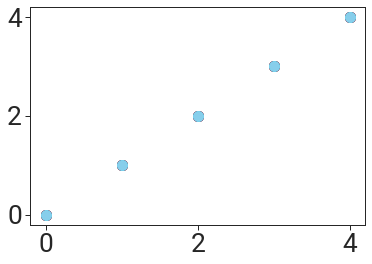

<Figure size 1440x180 with 0 Axes>

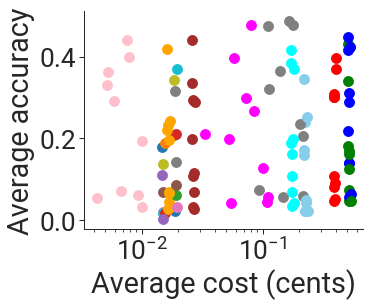

synthetic_efficiency
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


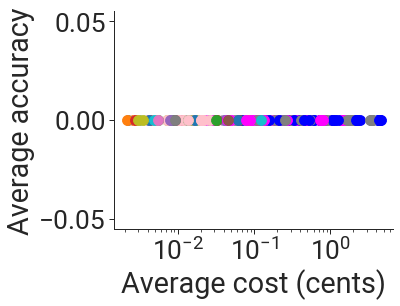

synthetic_reasoning:mode=variable_substitution
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


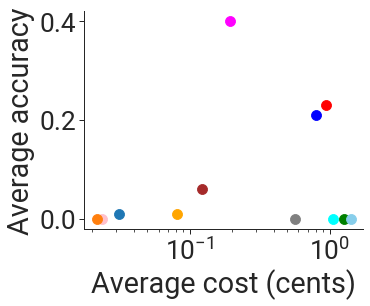

math
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


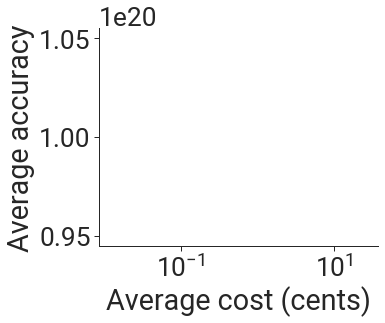

babi_qa:task=19
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


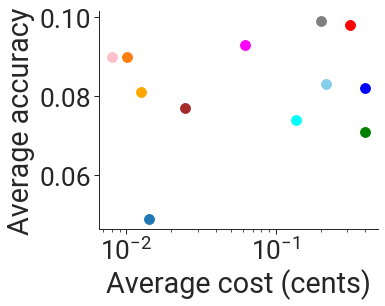

gsm
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


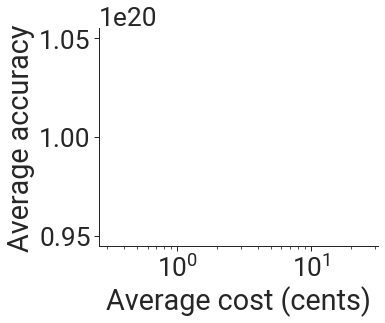

real_toxicity_prompts
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


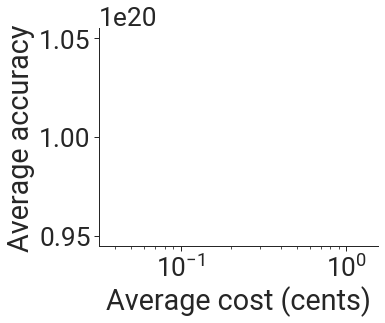

raft:subset=banking_77
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


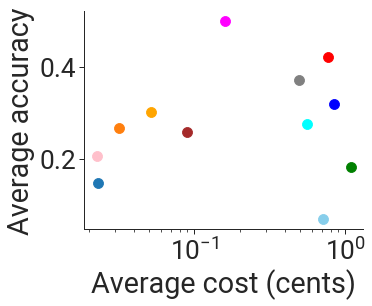

narrative_qa
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


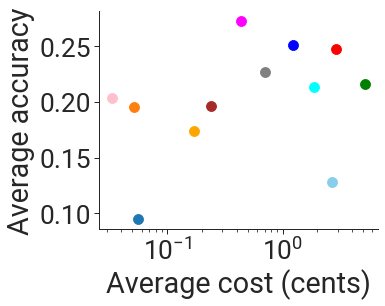

copyright
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


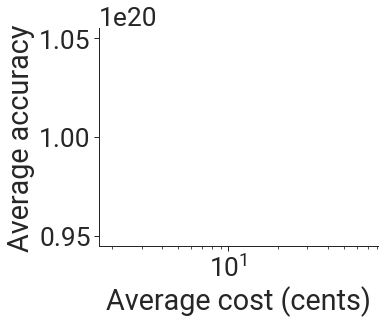

the_pile
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


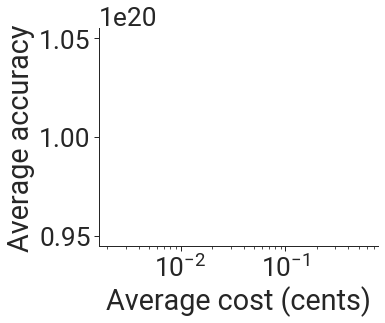

raft:subset=overruling
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


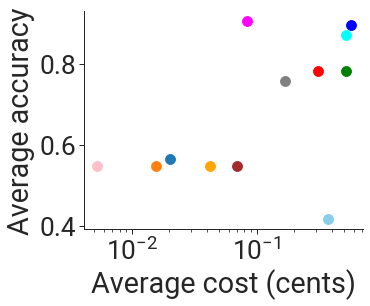

raft:subset=one_stop_english
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


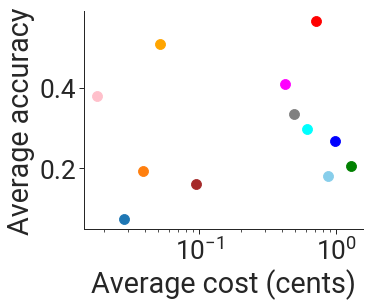

mmlu:subject=college_chemistry
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


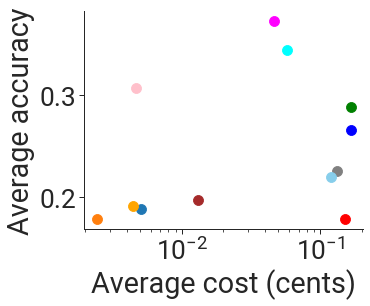

twitter_aae
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


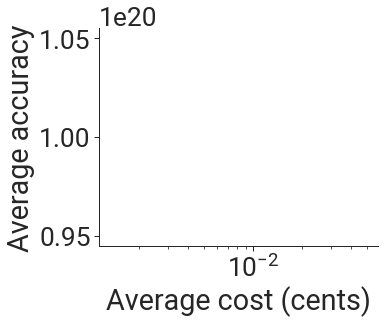

raft:subset=tai_safety_research
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


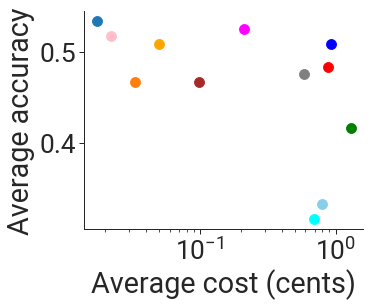

civil_comments:demographic=muslim
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


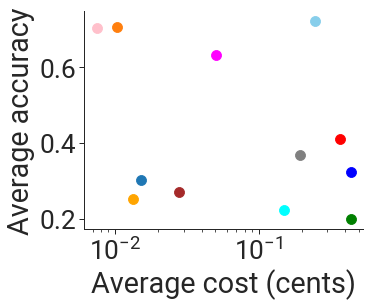

entity_data_imputation
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


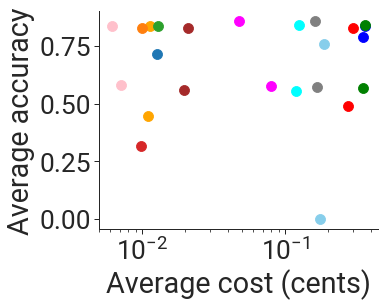

blimp
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


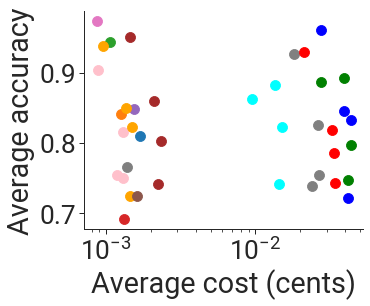

civil_comments:demographic=male
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


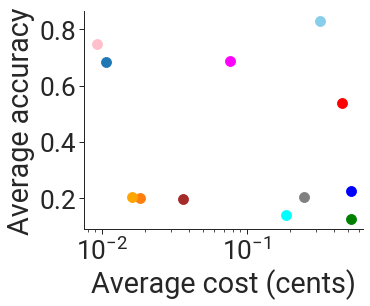

ice
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


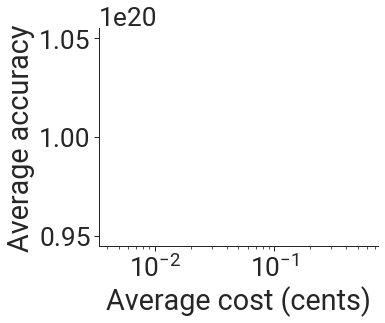

natural_qa:model=closedbook
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


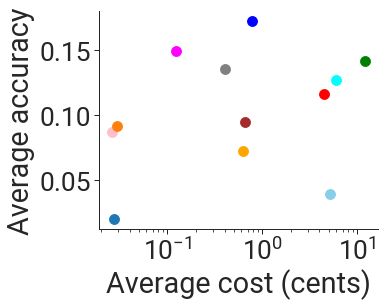

natural_qa:model=openbook_longans
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


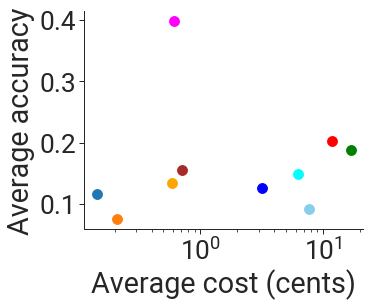

truthful_qa
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


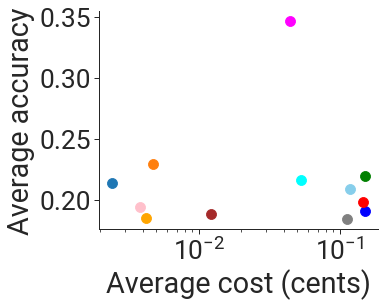

boolq
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


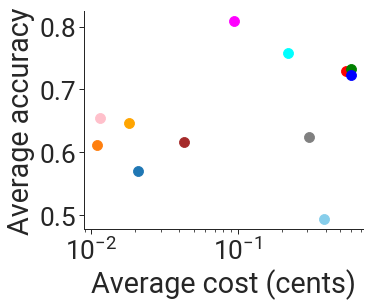

summarization_cnndm
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


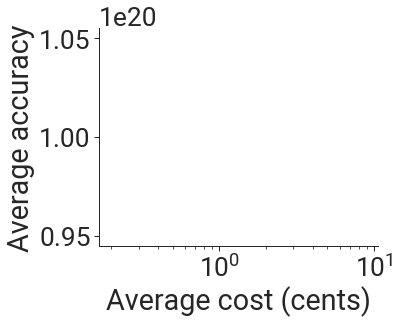

synthetic_reasoning_natural
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


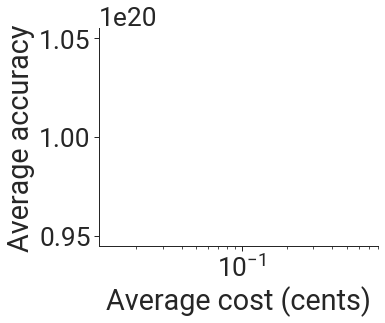

entity_matching:dataset=Abt_Buy
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


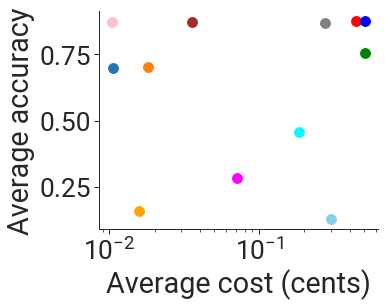

civil_comments:demographic=other_religions
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


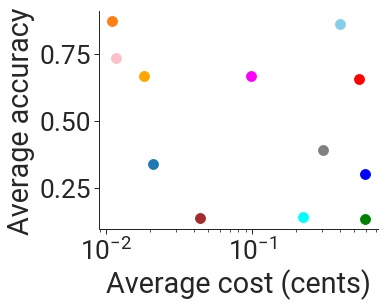

synthetic_reasoning:mode=induction
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


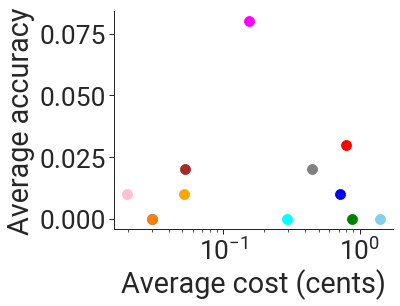

summarization_xsum
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


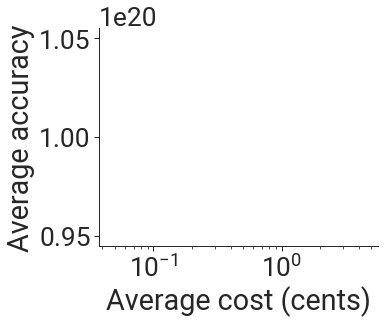

disinfo
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


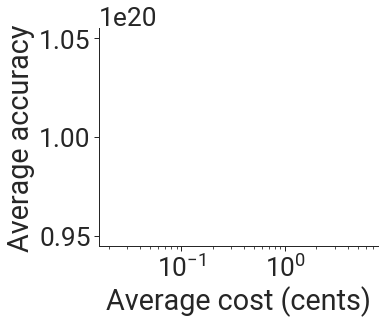

civil_comments:demographic=white
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


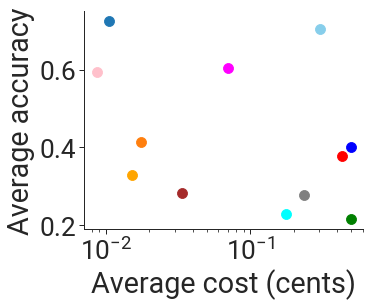

raft:subset=systematic_review_inclusion
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


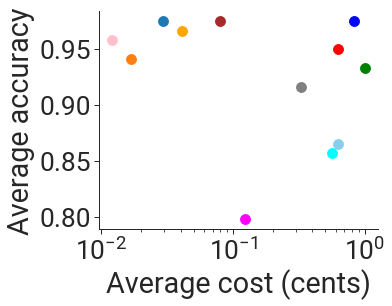

mmlu:subject=abstract_algebra
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


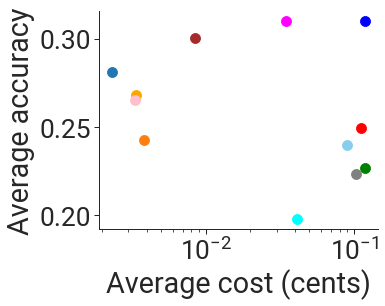

raft:subset=ade_corpus_v2
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


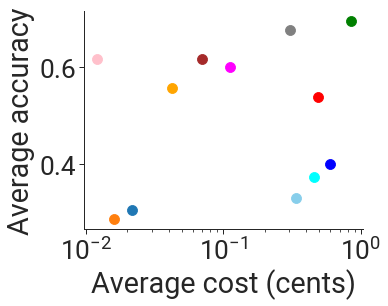

synthetic_reasoning:mode=pattern_match
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


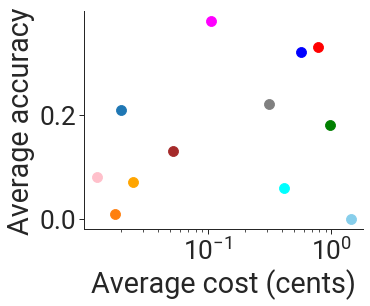

boolq:only_contrast=True
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


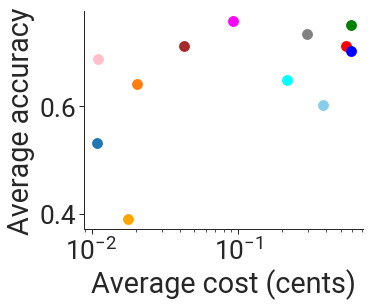

bold
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


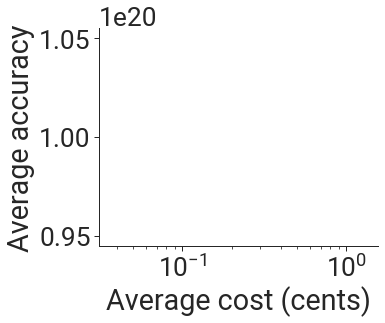

dyck_language_np=3
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


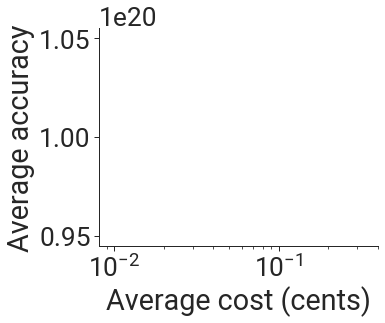

civil_comments:demographic=black
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


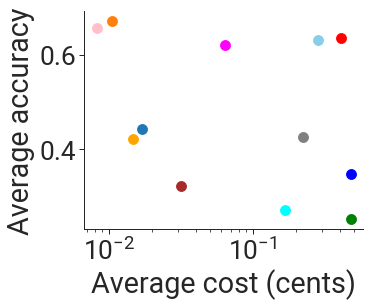

quac
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


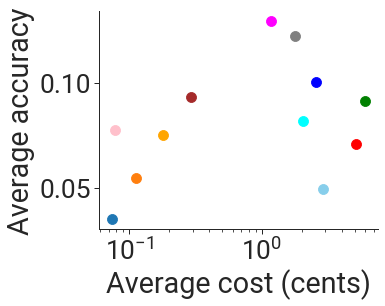

mmlu:subject=computer_security
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


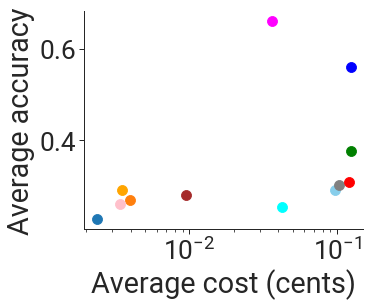

legal_support
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


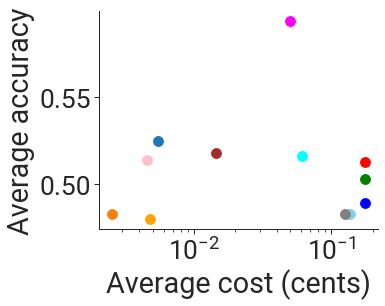

mmlu:subject=econometrics
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


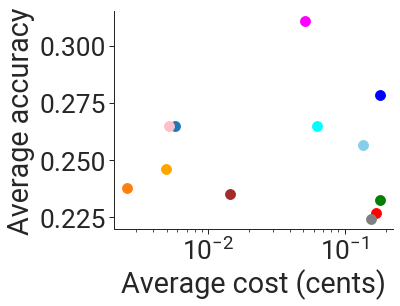

civil_comments:demographic=female
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


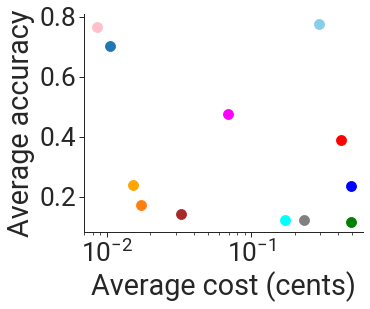

mmlu:subject=us_foreign_policy
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


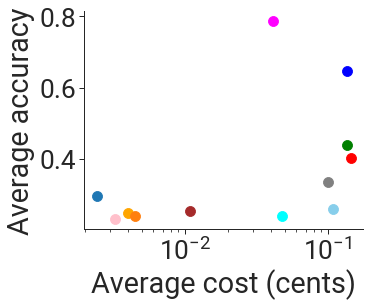

civil_comments:demographic=christian
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


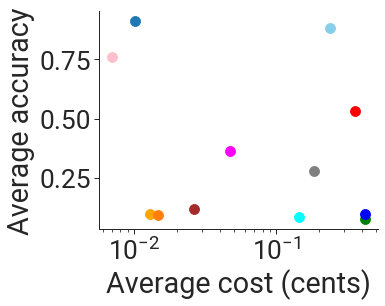

raft:subset=terms_of_service
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


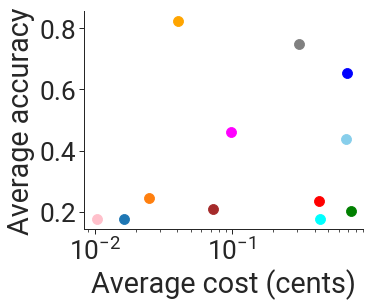

raft:subset=neurips_impact_statement_risks
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


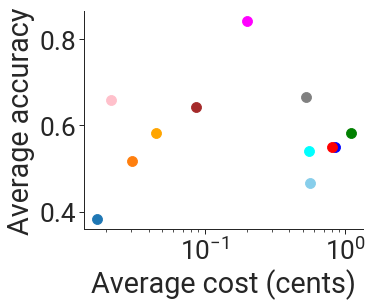

babi_qa:task=all
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


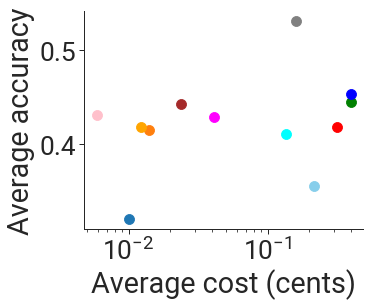

commonsense
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


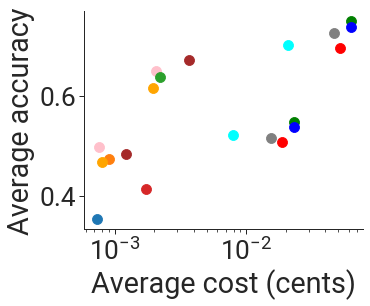

bbq
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


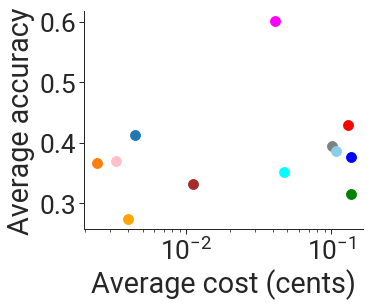

raft:subset=twitter_complaints
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


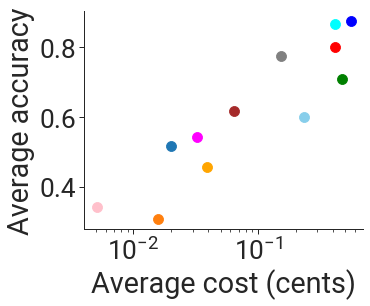

imdb:only_contrast=True
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


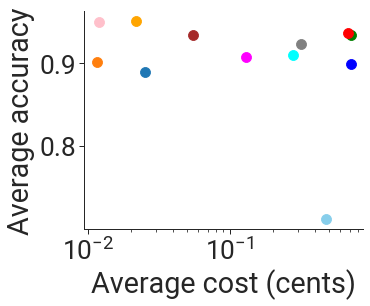

babi_qa:task=3
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


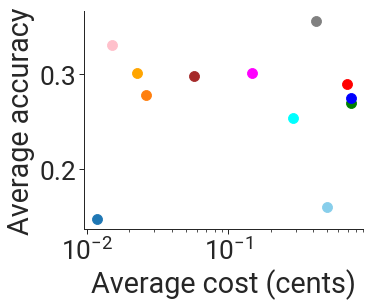

entity_matching:dataset=Beer
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


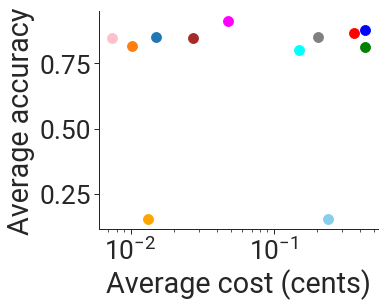

entity_matching:dataset=Dirty_iTunes_Amazon
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


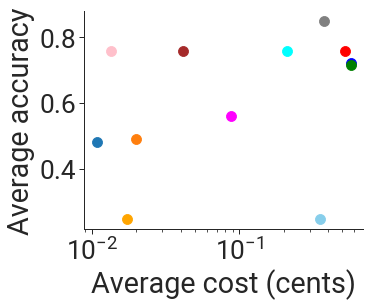

raft:subset=semiconductor_org_types
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


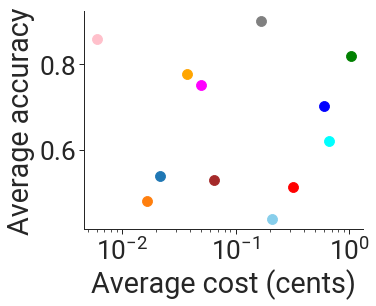

raft:subset=tweet_eval_hate
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


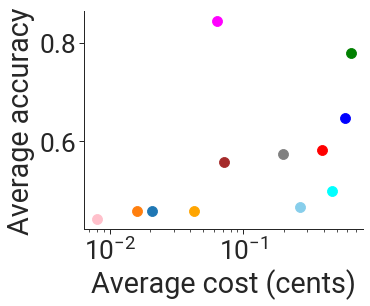

civil_comments:demographic=all
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


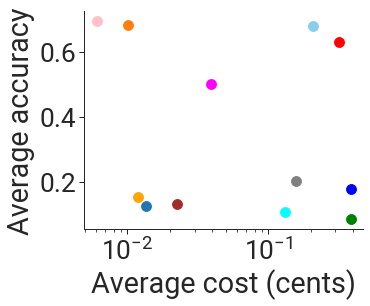

lsat_qa
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


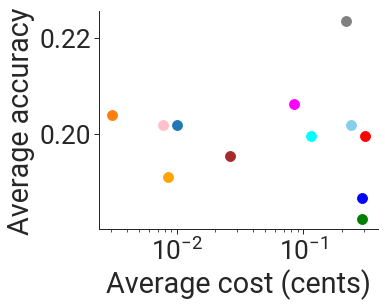

imdb
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


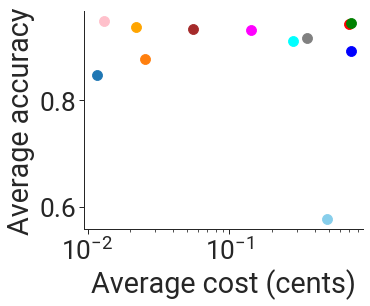

civil_comments:demographic=LGBTQ
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


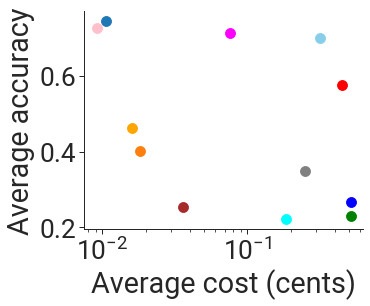

/Users/deepak/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/deepak/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


code
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


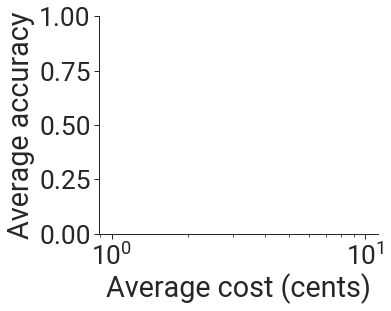

babi_qa:task=15
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


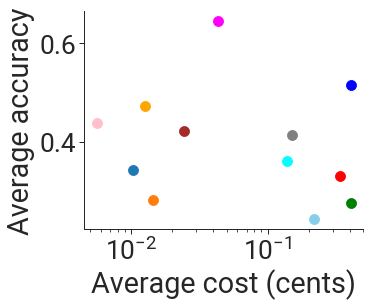

In [9]:
plot_efficiency_vs_capability("idealized_cost",
                              output_dir="../figures/efficiency_vs_capability/idealized_cost")

wikifact
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


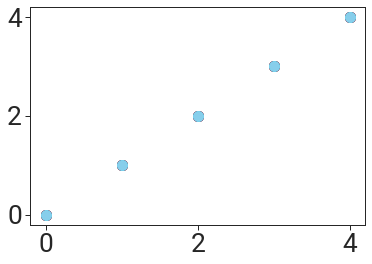

<Figure size 1440x180 with 0 Axes>

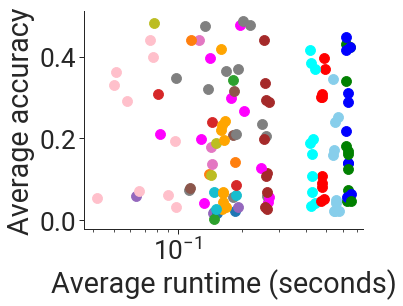

synthetic_efficiency
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


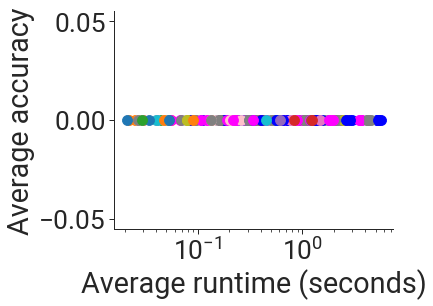

synthetic_reasoning:mode=variable_substitution
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


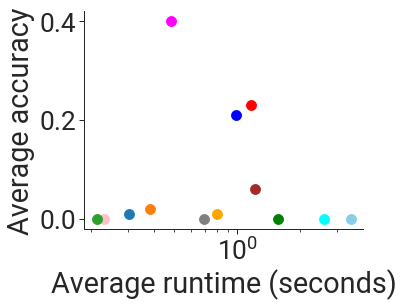

math
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


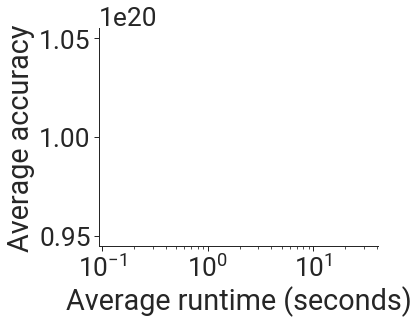

babi_qa:task=19
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


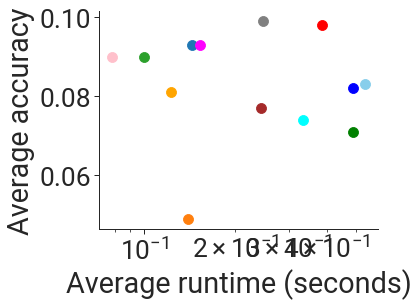

gsm
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


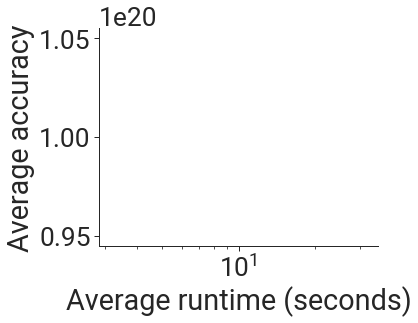

real_toxicity_prompts
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


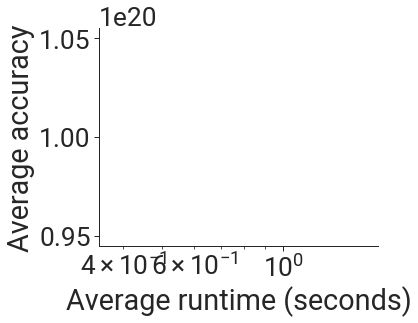

raft:subset=banking_77
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


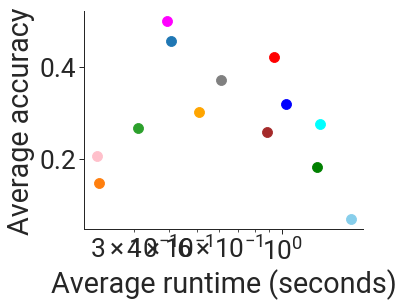

narrative_qa
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


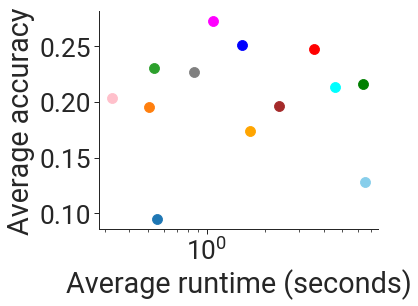

copyright
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


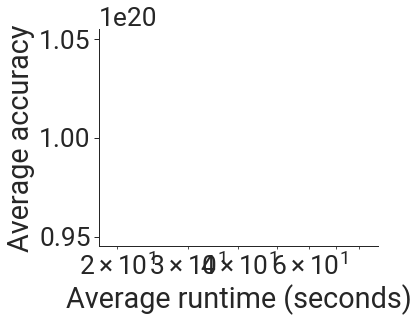

the_pile
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


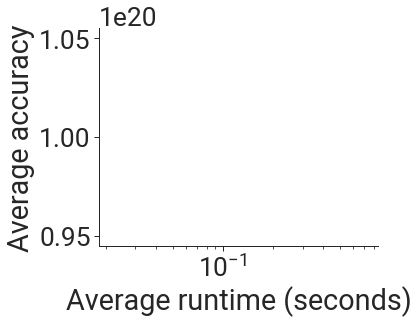

raft:subset=overruling
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


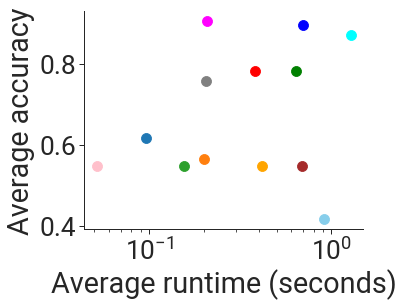

raft:subset=one_stop_english
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


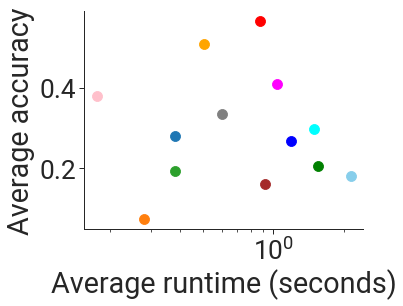

mmlu:subject=college_chemistry
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


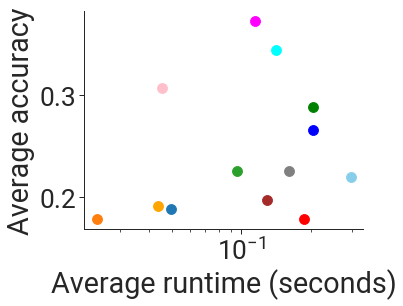

twitter_aae
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


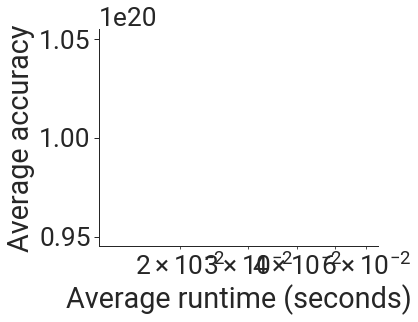

raft:subset=tai_safety_research
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


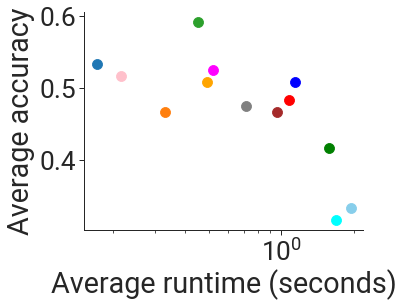

civil_comments:demographic=muslim
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


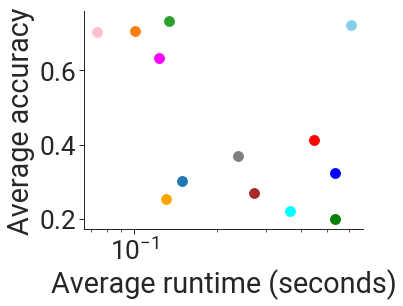

entity_data_imputation
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


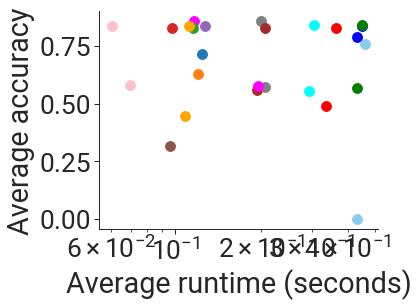

blimp
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


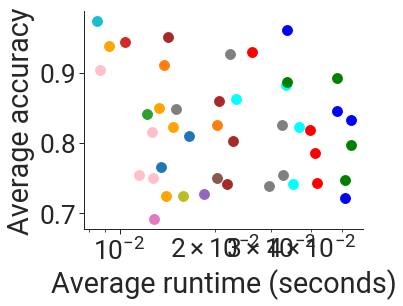

civil_comments:demographic=male
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


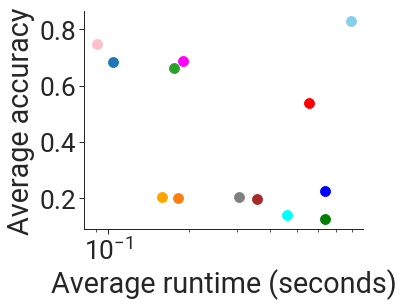

ice
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


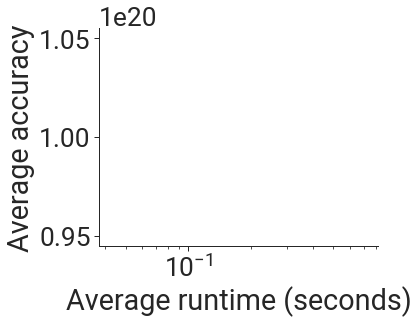

natural_qa:model=closedbook
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


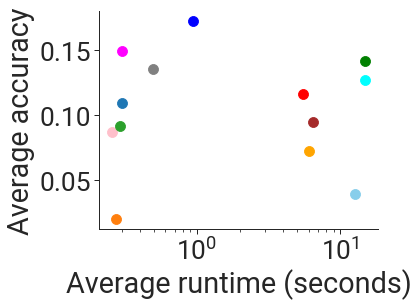

natural_qa:model=openbook_longans
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


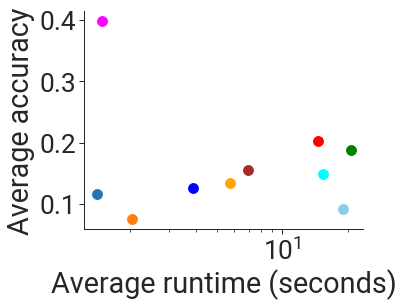

truthful_qa
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


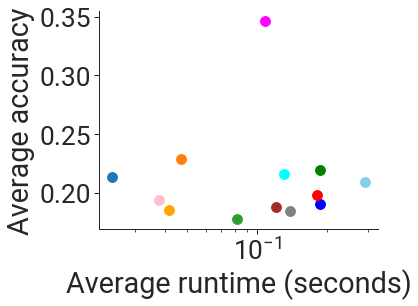

boolq
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


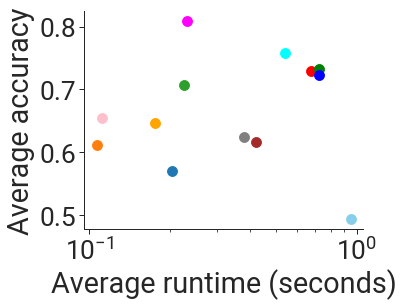

summarization_cnndm
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


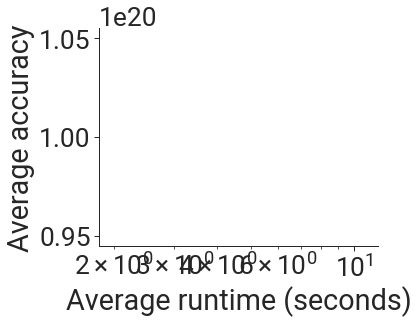

synthetic_reasoning_natural
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


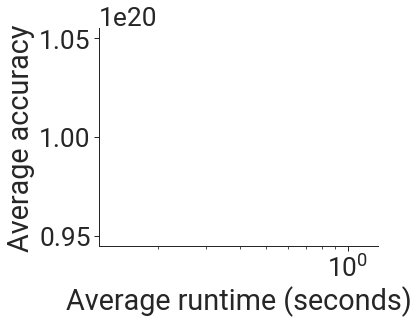

entity_matching:dataset=Abt_Buy
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


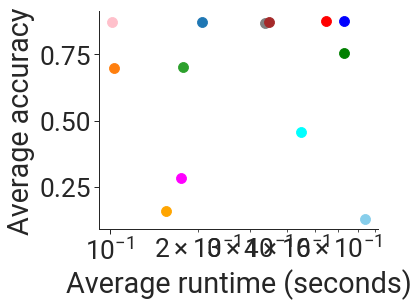

civil_comments:demographic=other_religions
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


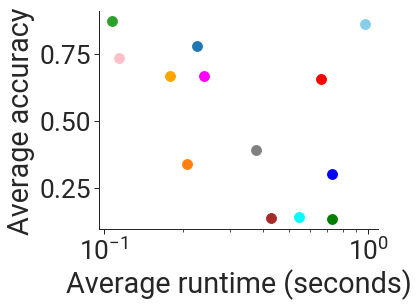

synthetic_reasoning:mode=induction
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


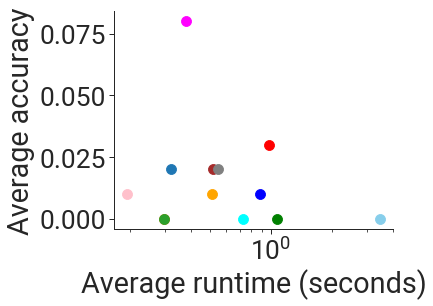

summarization_xsum
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


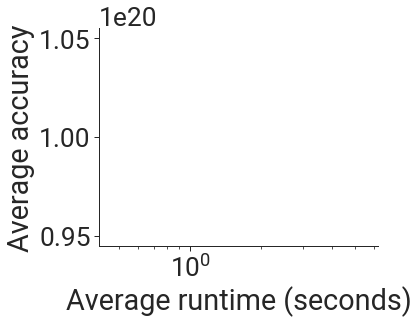

disinfo
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


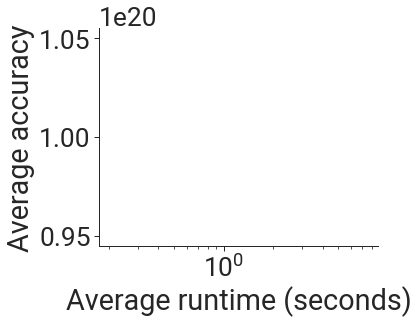

civil_comments:demographic=white
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


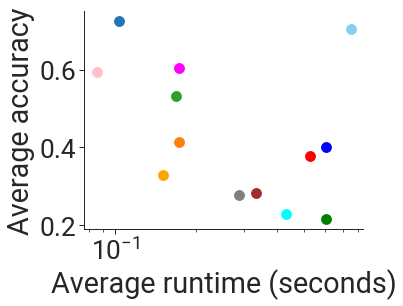

raft:subset=systematic_review_inclusion
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


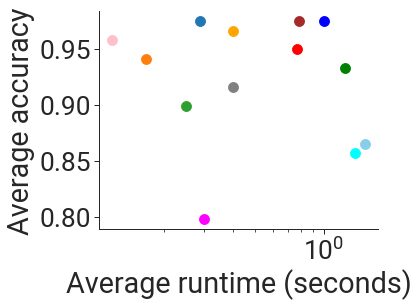

mmlu:subject=abstract_algebra
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


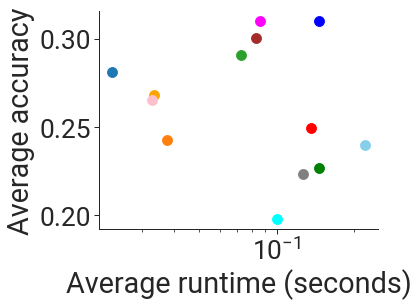

raft:subset=ade_corpus_v2
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


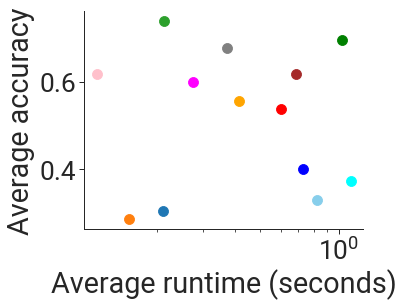

synthetic_reasoning:mode=pattern_match
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


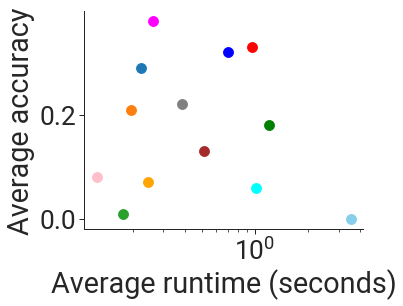

boolq:only_contrast=True
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


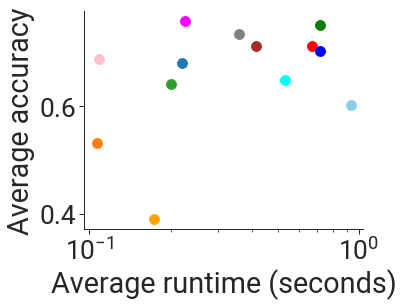

bold
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


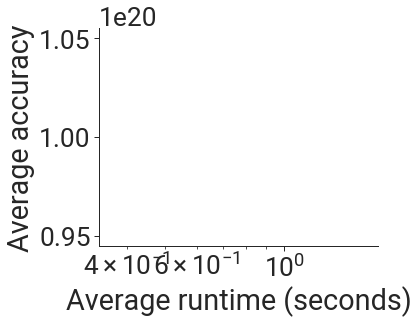

dyck_language_np=3
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


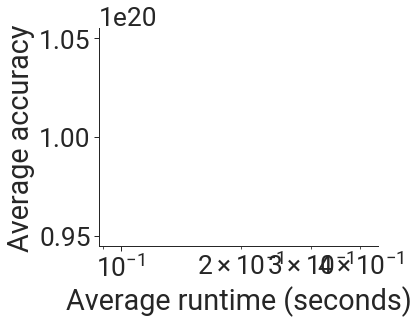

civil_comments:demographic=black
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


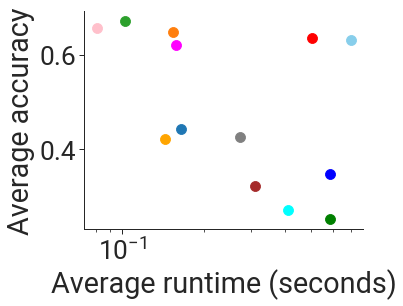

quac
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


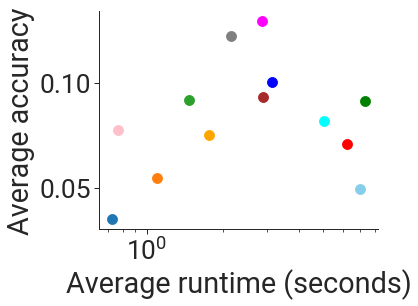

mmlu:subject=computer_security
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


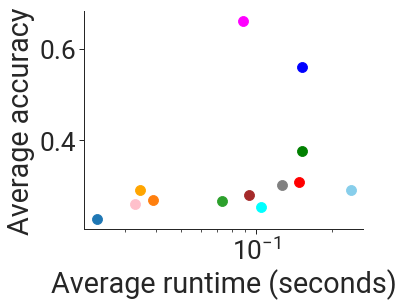

legal_support
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


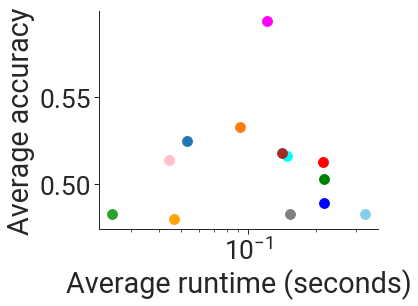

mmlu:subject=econometrics
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


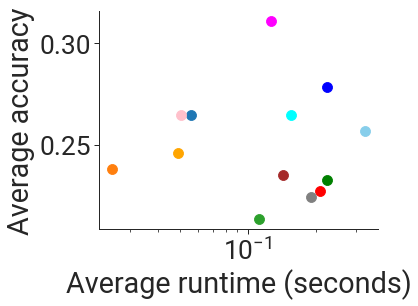

civil_comments:demographic=female
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


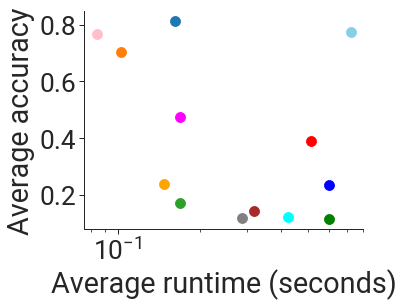

mmlu:subject=us_foreign_policy
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


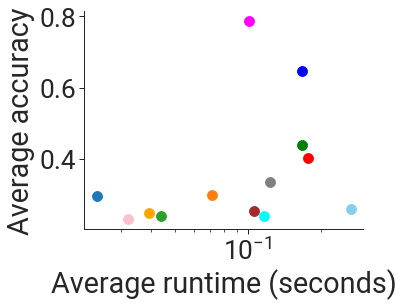

civil_comments:demographic=christian
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


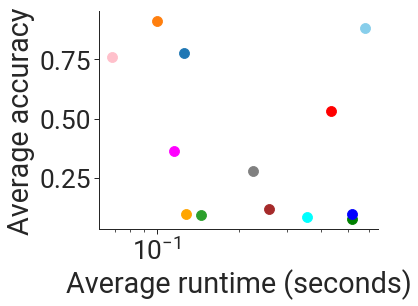

raft:subset=terms_of_service
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


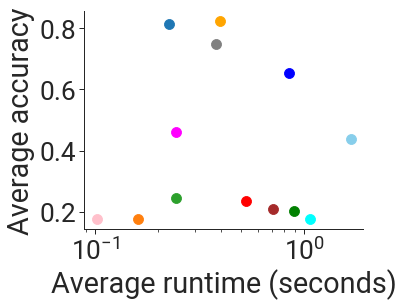

raft:subset=neurips_impact_statement_risks
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


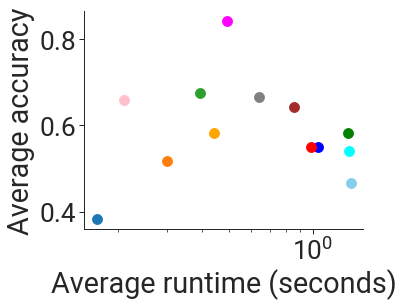

babi_qa:task=all
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


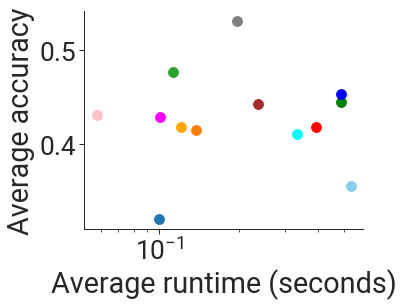

commonsense
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


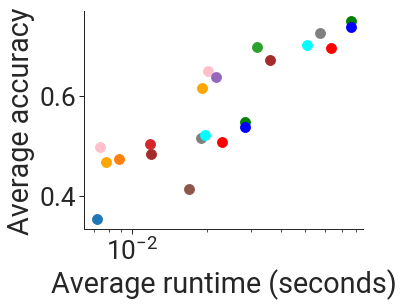

bbq
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


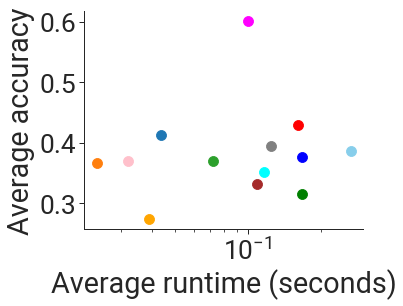

raft:subset=twitter_complaints
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


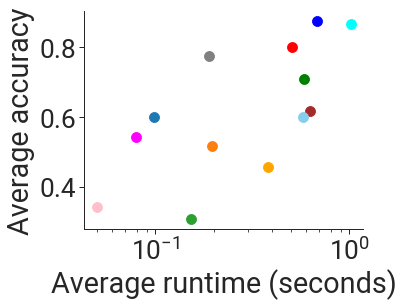

imdb:only_contrast=True
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


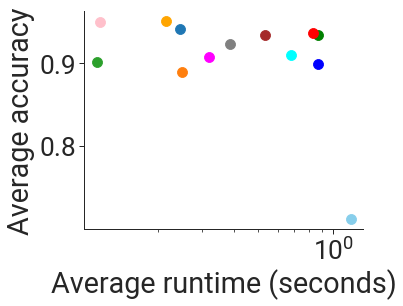

babi_qa:task=3
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


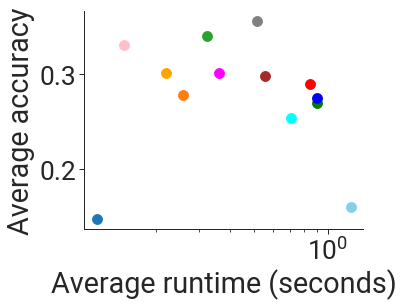

entity_matching:dataset=Beer
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


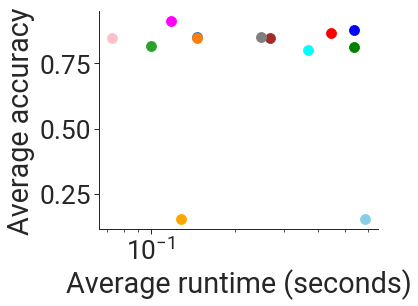

entity_matching:dataset=Dirty_iTunes_Amazon
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


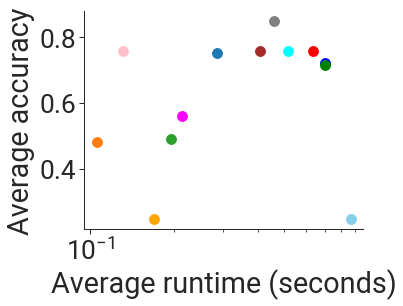

raft:subset=semiconductor_org_types
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


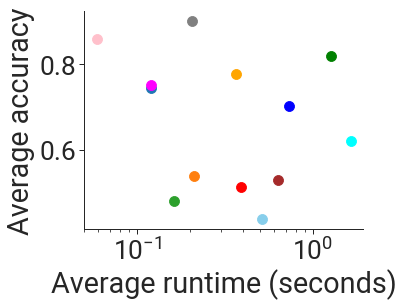

raft:subset=tweet_eval_hate
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


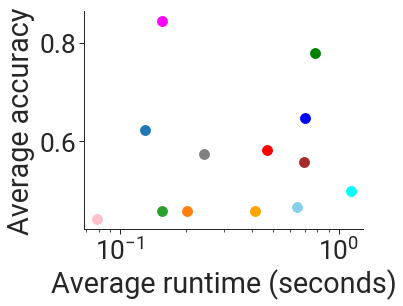

civil_comments:demographic=all
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


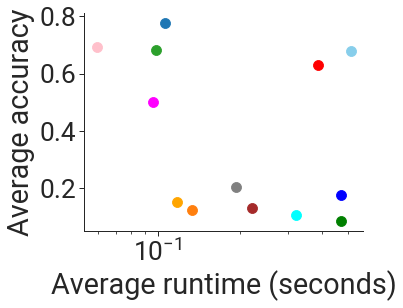

lsat_qa
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


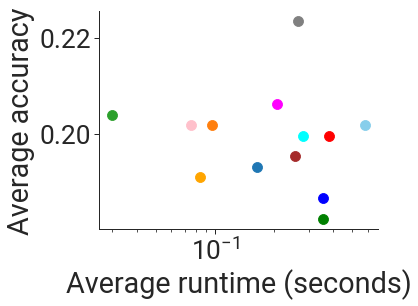

imdb
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


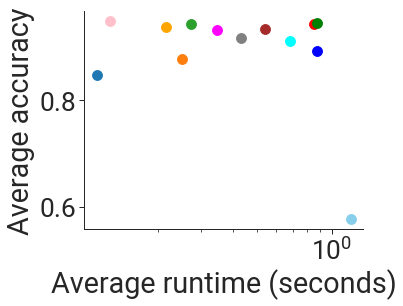

civil_comments:demographic=LGBTQ
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


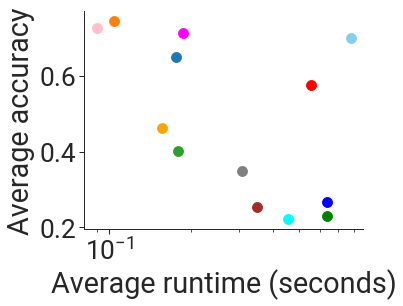

code
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


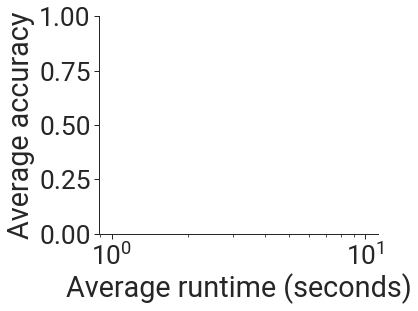

babi_qa:task=15
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


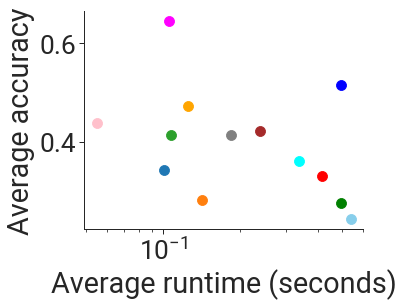

In [10]:
plot_efficiency_vs_capability("idealized_runtime",
                              output_dir="../figures/efficiency_vs_capability/idealized_runtime")

wikifact
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


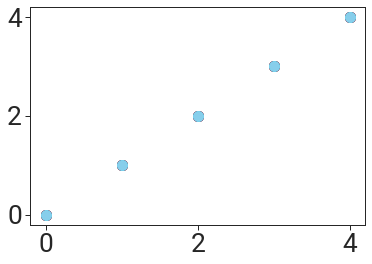

<Figure size 1440x180 with 0 Axes>

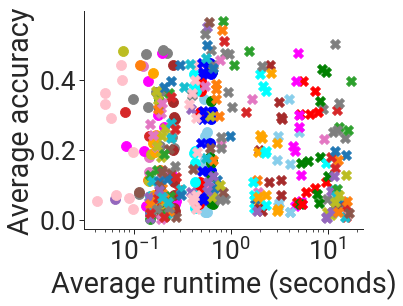

synthetic_efficiency
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


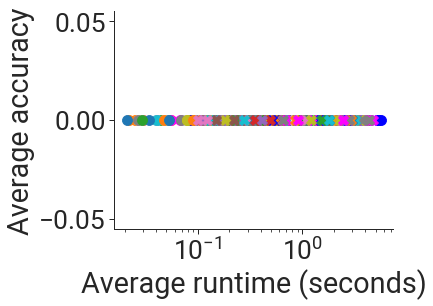

synthetic_reasoning:mode=variable_substitution
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


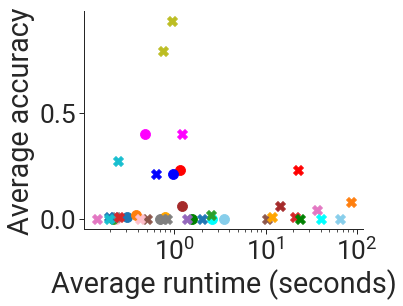

math
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


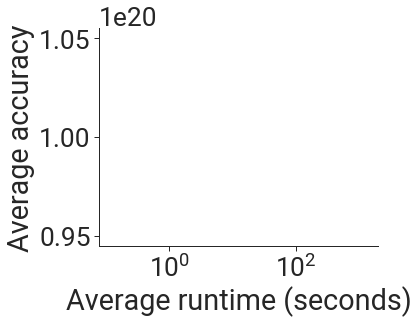

babi_qa:task=19
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


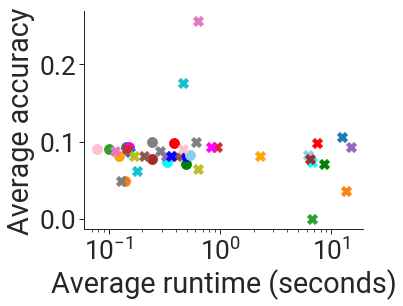

gsm
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


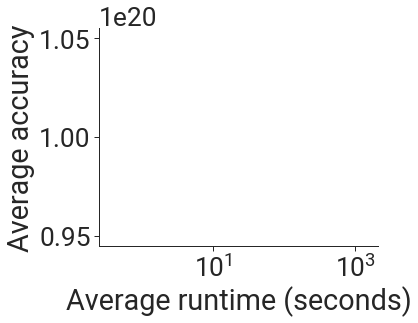

real_toxicity_prompts
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


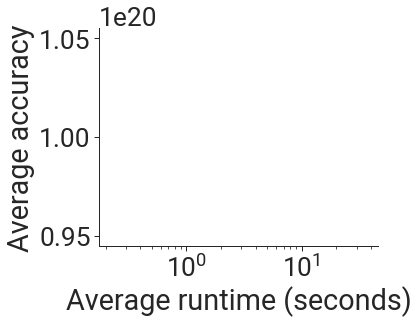

raft:subset=banking_77
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


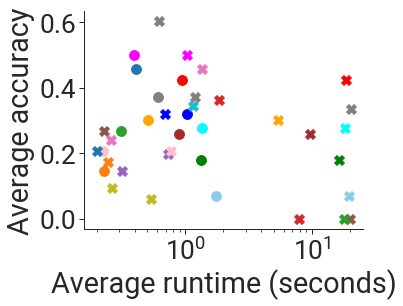

narrative_qa
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


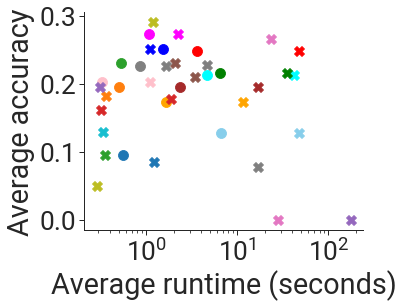

copyright
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


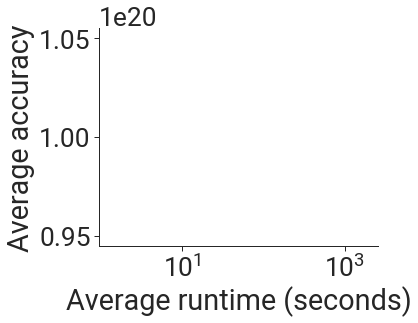

the_pile
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


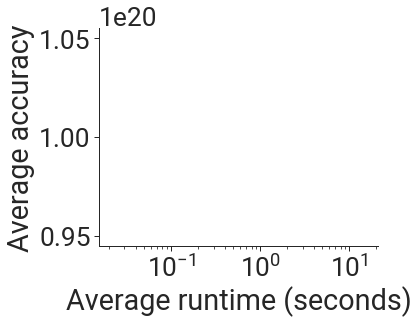

raft:subset=overruling
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


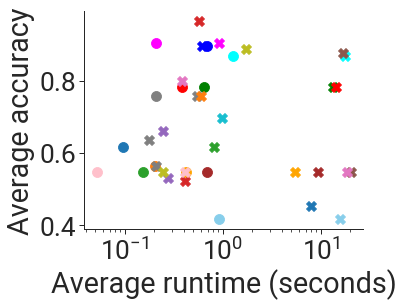

raft:subset=one_stop_english
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


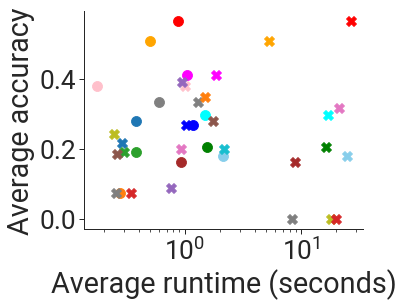

mmlu:subject=college_chemistry
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


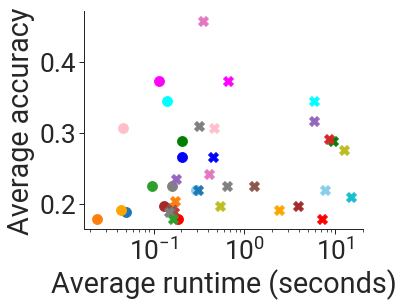

twitter_aae
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


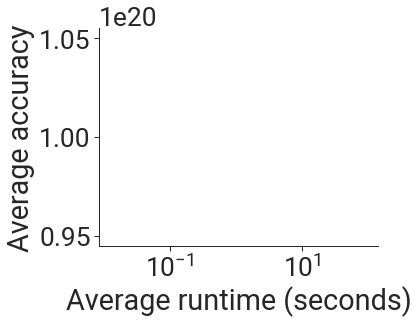

raft:subset=tai_safety_research
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


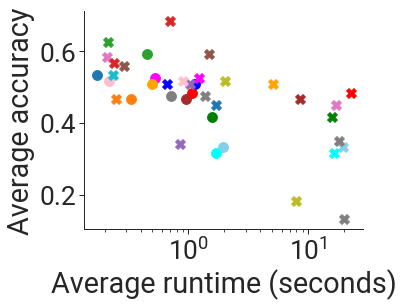

civil_comments:demographic=muslim
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


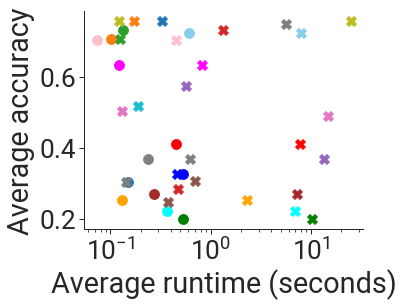

entity_data_imputation
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


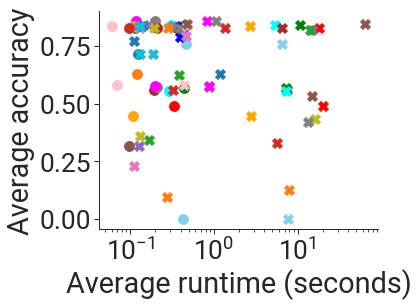

blimp
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


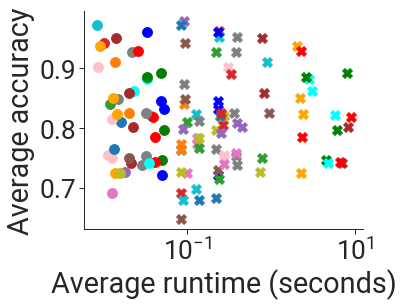

civil_comments:demographic=male
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


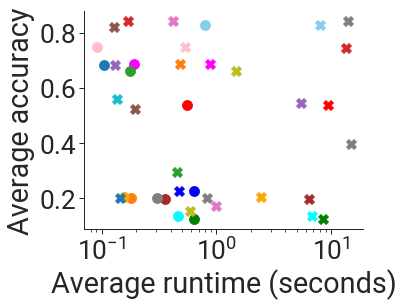

ice
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


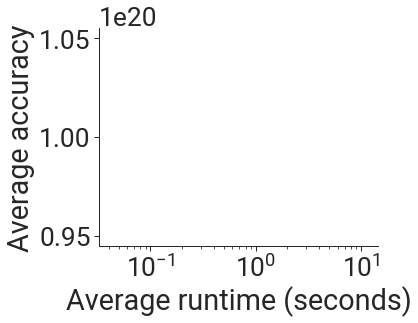

natural_qa:model=closedbook
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


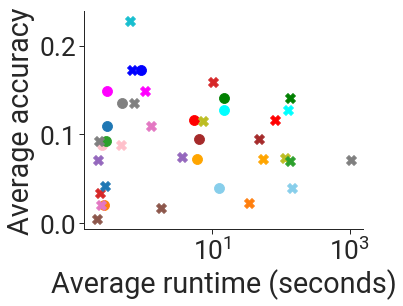

natural_qa:model=openbook_longans
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


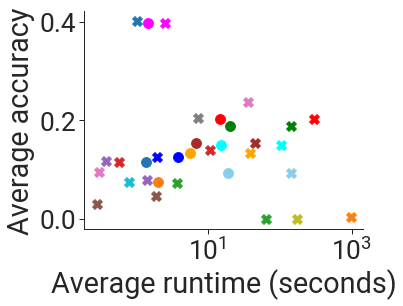

truthful_qa
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


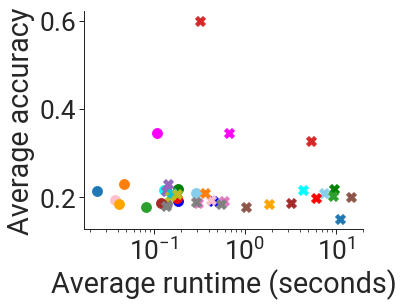

boolq
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


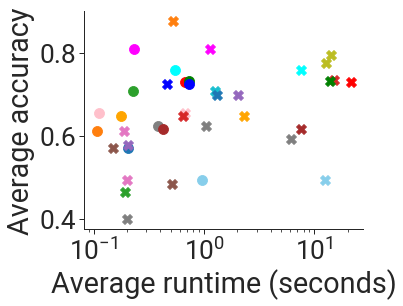

summarization_cnndm
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


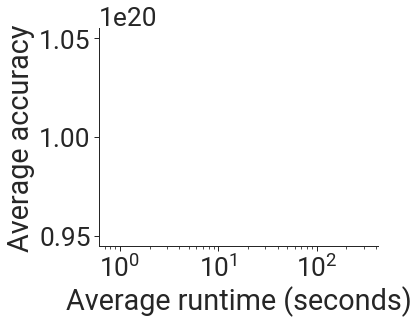

synthetic_reasoning_natural
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


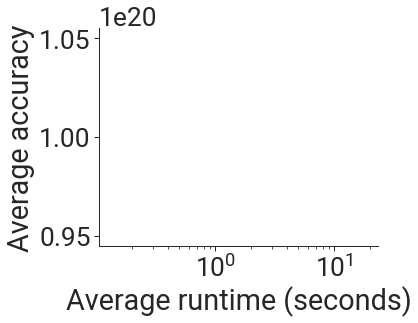

entity_matching:dataset=Abt_Buy
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


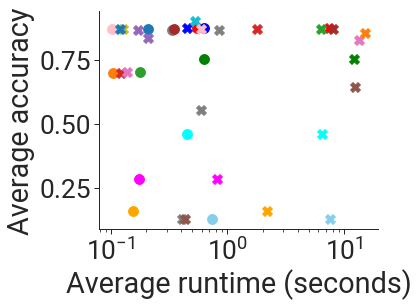

civil_comments:demographic=other_religions
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


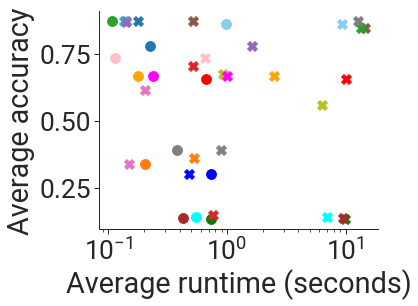

synthetic_reasoning:mode=induction
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


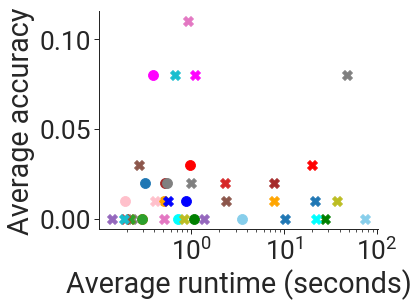

summarization_xsum
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


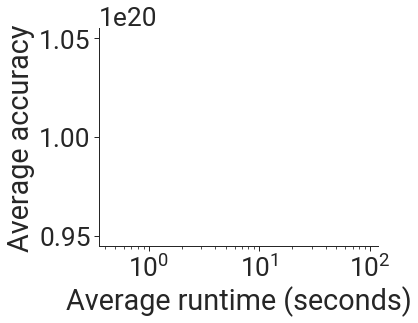

disinfo
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


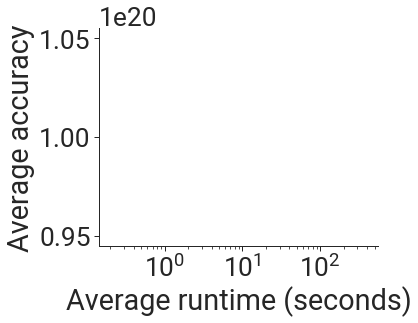

civil_comments:demographic=white
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


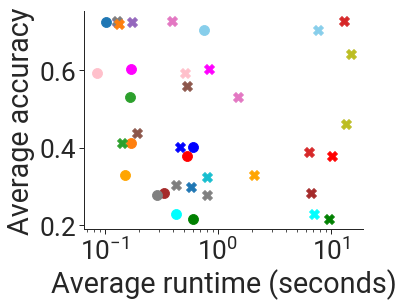

raft:subset=systematic_review_inclusion
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


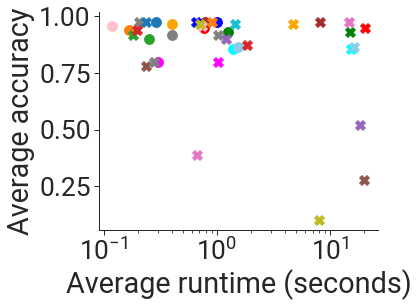

mmlu:subject=abstract_algebra
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


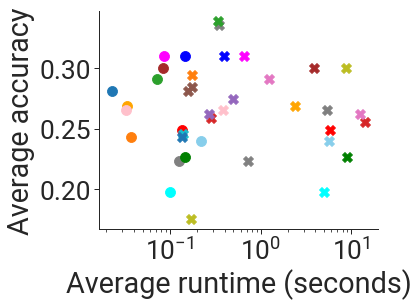

raft:subset=ade_corpus_v2
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


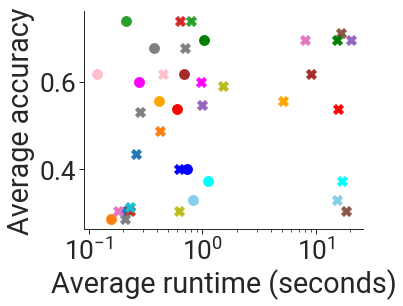

synthetic_reasoning:mode=pattern_match
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


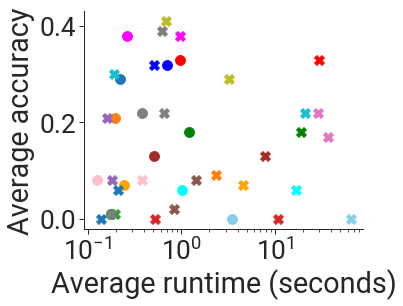

boolq:only_contrast=True
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


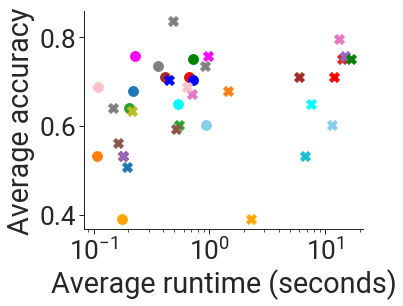

bold
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


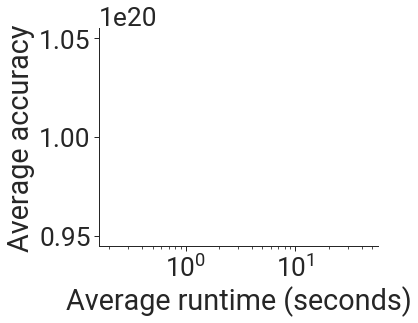

dyck_language_np=3
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


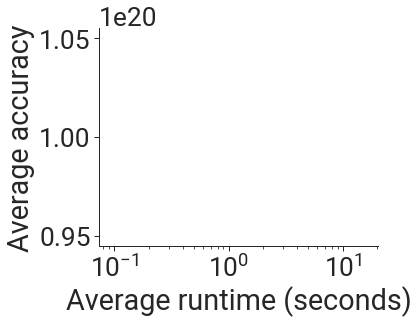

civil_comments:demographic=black
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


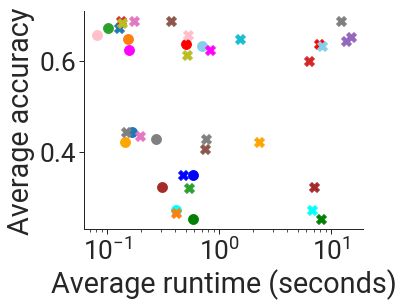

quac
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


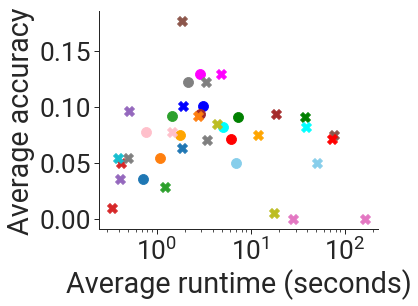

mmlu:subject=computer_security
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


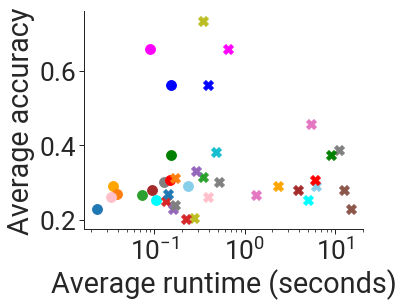

legal_support
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


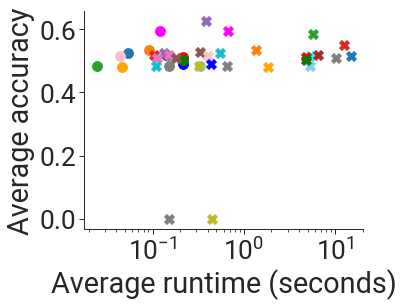

mmlu:subject=econometrics
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


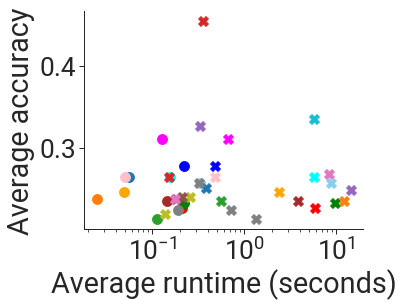

civil_comments:demographic=female
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


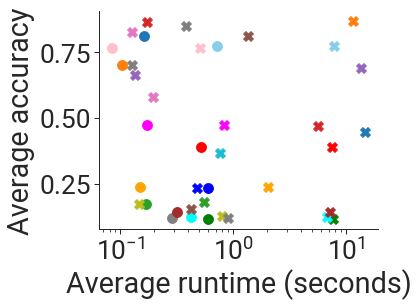

mmlu:subject=us_foreign_policy
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


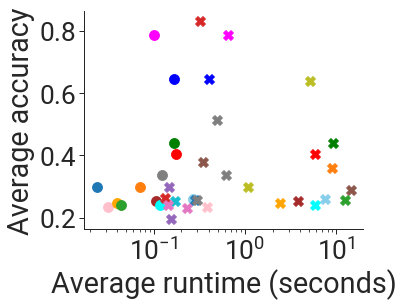

civil_comments:demographic=christian
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


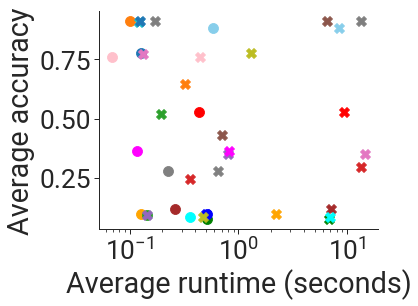

raft:subset=terms_of_service
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


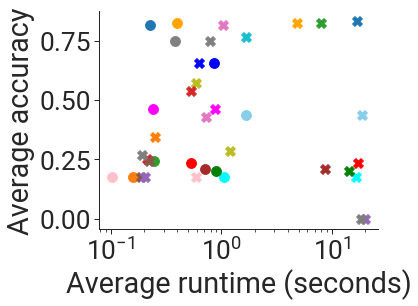

raft:subset=neurips_impact_statement_risks
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


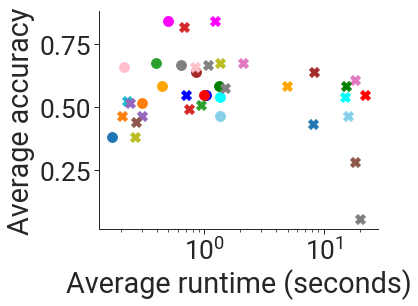

babi_qa:task=all
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


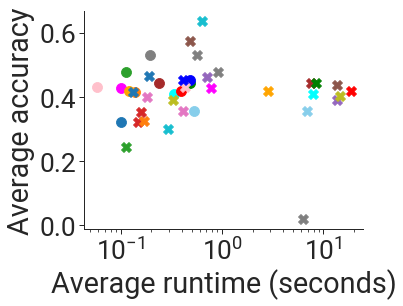

commonsense
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


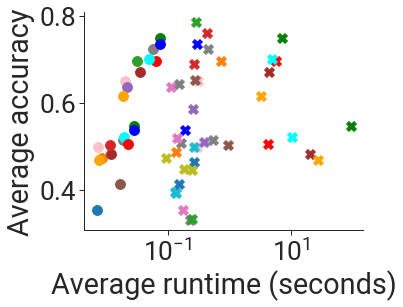

bbq
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


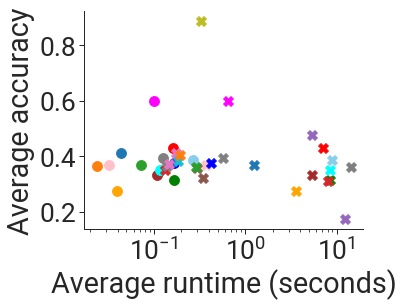

raft:subset=twitter_complaints
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


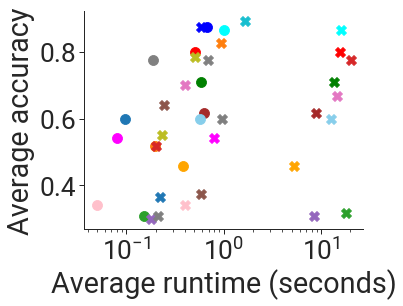

imdb:only_contrast=True
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


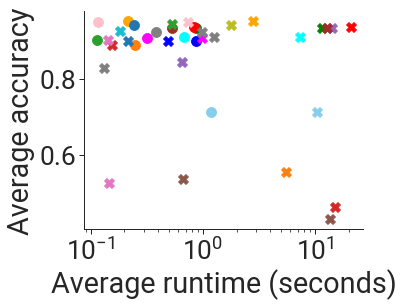

babi_qa:task=3
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


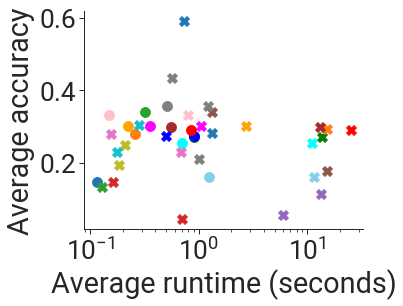

entity_matching:dataset=Beer
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


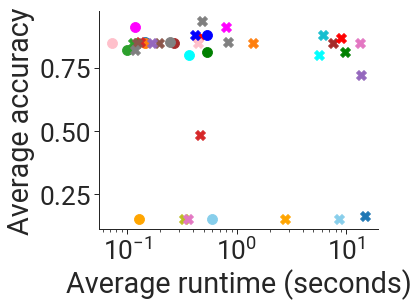

entity_matching:dataset=Dirty_iTunes_Amazon
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


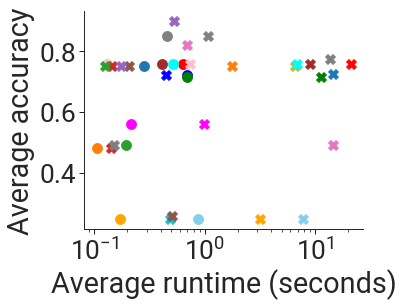

raft:subset=semiconductor_org_types
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


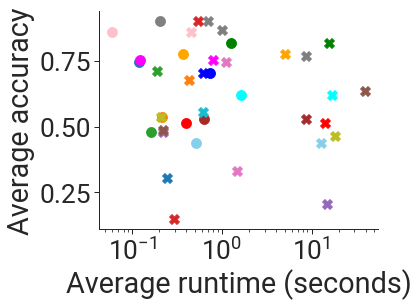

raft:subset=tweet_eval_hate
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


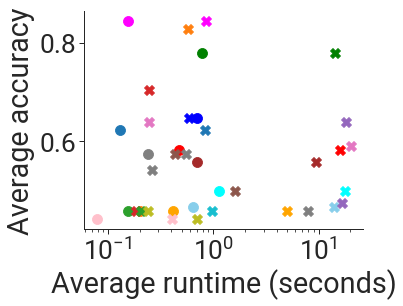

civil_comments:demographic=all
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


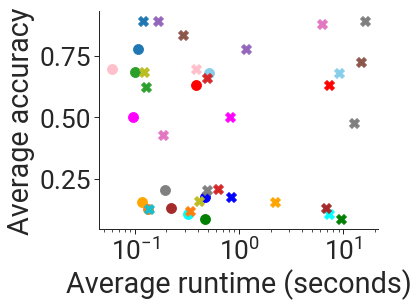

lsat_qa
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


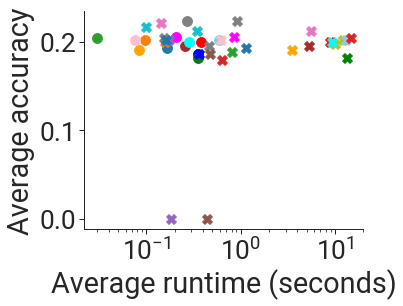

imdb
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


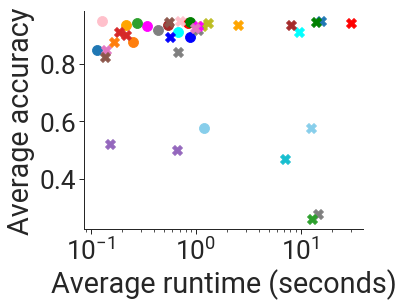

civil_comments:demographic=LGBTQ
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


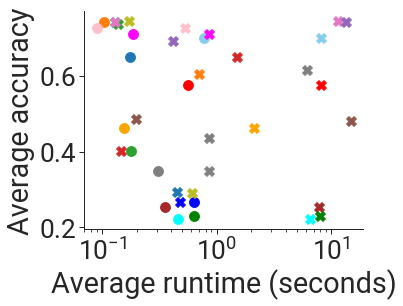

code
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


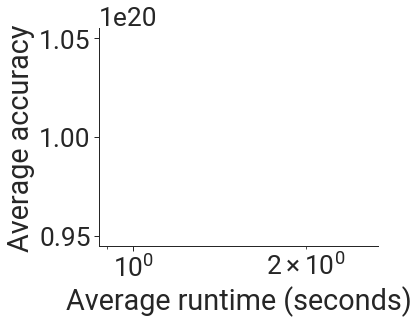

babi_qa:task=15
{'gooseai_gpt-j-6b': 'yellow', 'together_gpt-j-6b': 'orange', 'gooseai_gpt-neo-20b': 'purple', 'together_gpt-neox-20b': 'brown', 'openai_davinci': 'blue', 'together_opt-175b': 'green', 'ai21_j1-large': 'pink', 'ai21_j1-jumbo': 'grey', 'mt_nlg': 'black', 'anthropic_stanford-online-all-v4-s3': 'magenta', 'together_bloom': 'red', 'together_opt-66b': 'aqua', 'together_yalm': 'skyblue'}


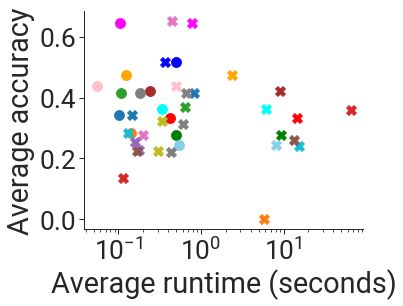

In [11]:
plot_efficiency_vs_capability("idealized_runtime_and_runtime",
                              output_dir="../figures/efficiency_vs_capability/idealized_runtime_and_runtime")